# Importing the necessary modules

In [12]:
import librosa
import librosa.display
import os
import matplotlib.pyplot as plt
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D, BatchNormalization , Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import classification_report

# Data Exploration/ Data Visualization

In [13]:
def plot_waveform(path, num_rows=2, num_cols=5):
    folders = [folder for folder in os.listdir(path) if os.path.isdir(os.path.join(path, folder))]
    total_subplots = num_rows * num_cols
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 6))

    for i, folder in enumerate(folders):
        if i >= total_subplots:
            break

        folder_path = os.path.join(path, folder)
        audio_files = [file for file in os.listdir(folder_path) if file.endswith('.wav')]

        for j, file in enumerate(audio_files):
            print(file)
            if j >= num_cols:
                break

            file_path = os.path.join(folder_path, file)
            audio, sr = librosa.load(file_path)
            row = i // num_cols
            col = i % num_cols
            plot = librosa.display.waveshow(audio, sr=sr, ax=axs[row, col])
            axs[row, col].set_title(f'{folder}')

    plt.tight_layout()
    fig.suptitle("Waveforms")
    fig.subplots_adjust(top=0.90)
    plt.savefig('waveforms_for_audio_files.png', dpi=300)
    plt.show()


In [18]:
directory_path = 'genres/'

blues.00000.wav
blues.00001.wav
blues.00002.wav
blues.00003.wav
blues.00004.wav
blues.00005.wav
classical.00000.wav
classical.00001.wav
classical.00002.wav
classical.00003.wav
classical.00004.wav
classical.00005.wav
country.00000.wav
country.00001.wav
country.00002.wav
country.00003.wav
country.00004.wav
country.00005.wav
disco.00000.wav
disco.00001.wav
disco.00002.wav
disco.00003.wav
disco.00004.wav
disco.00005.wav
hiphop.00000.wav
hiphop.00001.wav
hiphop.00002.wav
hiphop.00003.wav
hiphop.00004.wav
hiphop.00005.wav
jazz.00000.wav
jazz.00001.wav
jazz.00002.wav
jazz.00003.wav
jazz.00004.wav
jazz.00005.wav
metal.00000.wav
metal.00001.wav
metal.00002.wav
metal.00003.wav
metal.00004.wav
metal.00005.wav
pop.00000.wav
pop.00001.wav
pop.00002.wav
pop.00003.wav
pop.00004.wav
pop.00005.wav
reggae.00000.wav
reggae.00001.wav
reggae.00002.wav
reggae.00003.wav
reggae.00004.wav
reggae.00005.wav
rock.00000.wav
rock.00001.wav
rock.00002.wav
rock.00003.wav
rock.00004.wav
rock.00005.wav


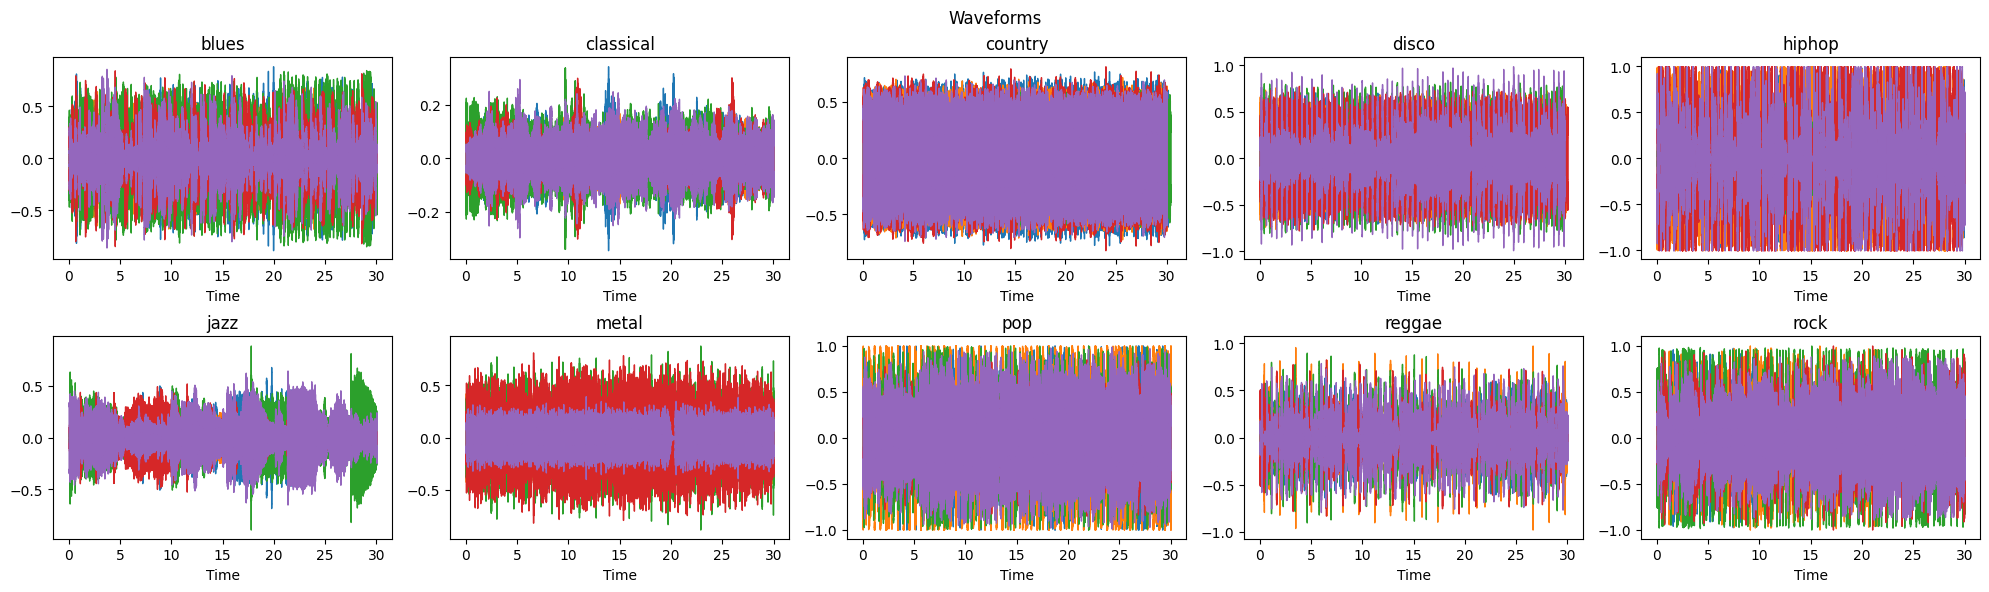

In [15]:
plot_waveform(directory_path)

In [16]:
def plot_mel_spectrogram(path, num_rows=2, num_cols=5):
    # List all subdirectories (folders) in the specified directory
    folders = next(os.walk(path))[1]

    # Create a figure with subplots
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(16, 8), squeeze=False)

    # Iterate over the folders and plot the spectrogram for each audio file
    for i, folder in enumerate(folders):
        if i >= num_rows * num_cols:
            break  # Limit the number of genres to plot based on the number of subplots

        folder_path = os.path.join(path, folder)
        for j, file in enumerate(os.listdir(folder_path)):
            if file.endswith('.wav') and j < num_cols:
                file_path = os.path.join(folder_path, file)
                audio, sr = librosa.load(file_path)
                spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
                log_spectrogram = librosa.amplitude_to_db(spectrogram, ref=np.max)

                row = i // num_cols
                col = i % num_cols

                axs[row, col].imshow(log_spectrogram, aspect='auto', origin='lower', cmap='hot')
                axs[row, col].set_title(f'{folder}')
                axs[row, col].set_xlabel('Time')
                axs[row, col].set_ylabel('Mel Frequency')

    plt.tight_layout()
    fig.subplots_adjust(top=0.90)
    fig.suptitle("Mel Spectrogram")
    plt.savefig('spectrograms_for_audio_files.png', dpi=300)
    plt.show()



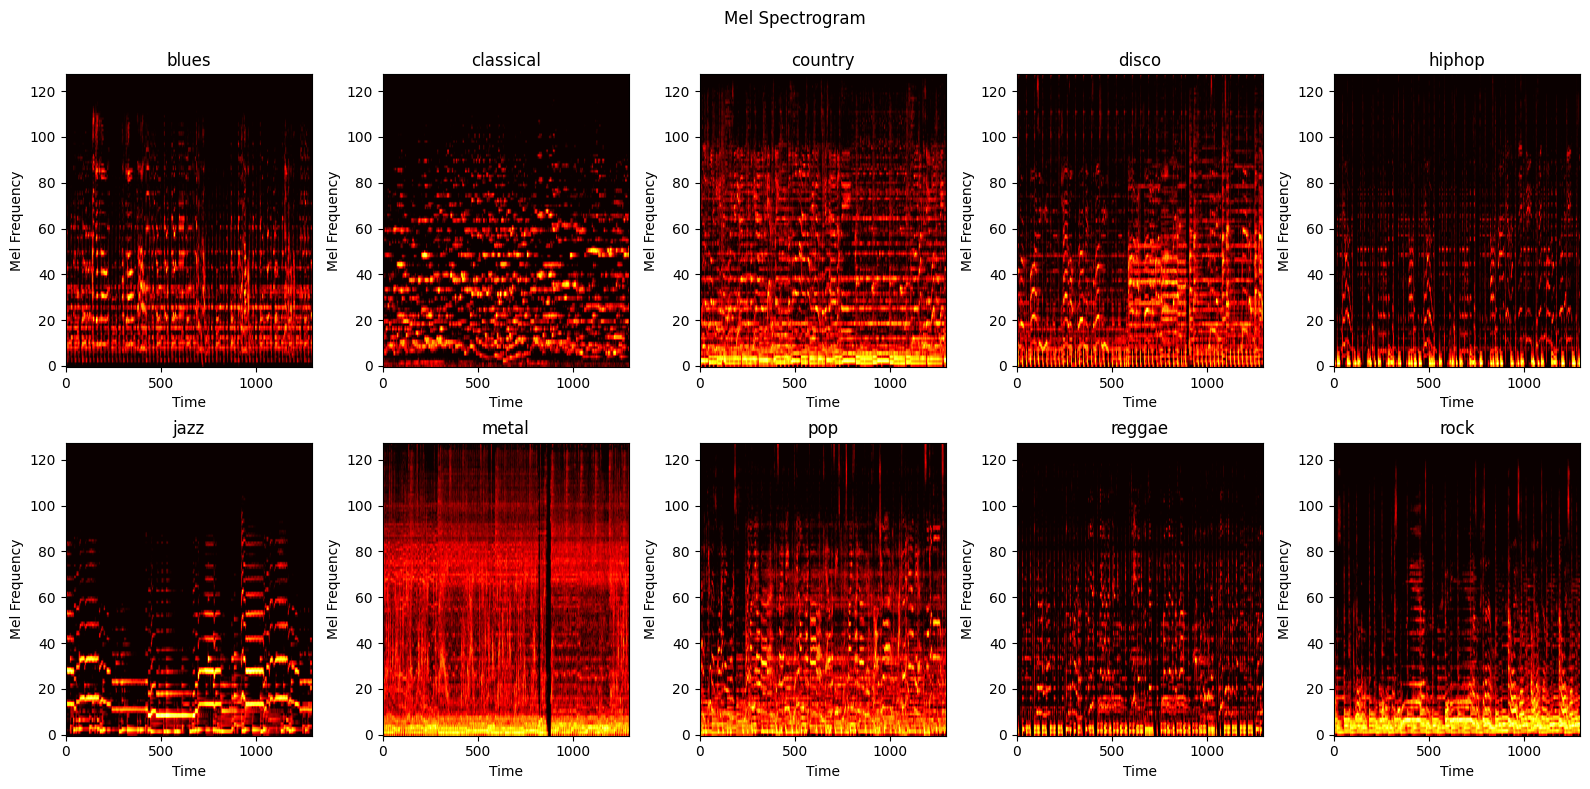

In [19]:
plot_mel_spectrogram(directory_path, num_rows=2, num_cols=5)

# Reading in the Data

In [20]:
def load_data(file_path):
    try:
        with open(file_path) as file:
            data = json.load(file)
            mel_spectrograms = data['mel_spectrograms']
            targets = data['targets']
        return mel_spectrograms, targets
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON: {e.msg} at line {e.lineno}, column {e.colno}")


In [22]:
file_path = "extracted_features.json"
try:
    X, y = load_data(file_path)
except FileNotFoundError:
    print("File not found!")

In [23]:
print(type(X))

<class 'list'>


# preparing the data to passed to the model

In [24]:
def prepare_data(X, y, test_size=0.1, validation_size=0.1):
    # Splitting the data into test and train sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    # Splitting the training set into training and validation datasets
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # Adding a new axis to the numpy arrays to make them 4D arrays
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test


In [25]:
X_train, X_validation, X_test, y_train, y_validation , y_test = prepare_data(np.array(X), np.array(y))

# Creating the CNN model

In [26]:
def cnn_model(input_shape):
    # Create the model
    neural_network = Sequential()

    # Create the 1st Convolutional Layer
    neural_network.add(Conv2D(32, (2, 2), activation='relu', input_shape=input_shape))
    neural_network.add(MaxPool2D((2, 2), strides=(1, 1), padding='same'))
    neural_network.add(BatchNormalization())

    # Create the 2nd Convolutional Layer
    neural_network.add(Conv2D(64, (2, 2), activation='relu'))
    neural_network.add(MaxPool2D((2, 2), strides=(1, 1), padding='same'))
    neural_network.add(BatchNormalization())

    # Create the 3rd Convolutional Layer
    neural_network.add(Conv2D(32, (2, 2), activation='relu'))
    neural_network.add(MaxPool2D((2, 2), strides=(1, 1), padding='same'))
    neural_network.add(BatchNormalization())

    # Flatten the Output and feed it into a dense layer
    neural_network.add(Flatten())
    neural_network.add(Dense(64, activation='relu'))
    neural_network.add(Dropout(0.3))

    # Output layer
    neural_network.add(Dense(10, activation='softmax'))

    return neural_network


# Initiating the CNN model

In [27]:
# The input shape for the neural network
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

# Define the metrics
precision = Precision()
recall = Recall()

#initializing the model
model= cnn_model(input_shape)

# Compile the model with Adam optimizer
optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy',precision, recall])

# Summary of the Model

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 127, 4, 32)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 4, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 127, 4, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 3, 64)        8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 126, 3, 64)       0         
 2D)                                                             
                                                        

# Training the Model

In [29]:
hist = model.fit(X_train, y_train, epochs=50, validation_data=(X_validation,y_validation), batch_size=16)

Epoch 1/50
1013/1013 [==============================] - 22s 7ms/step - loss: 2.0415 - accuracy: 0.2822 - precision: 0.6090 - recall: 0.0999 - val_loss: 1.9032 - val_accuracy: 0.3156 - val_precision: 0.7433 - val_recall: 0.1078
Epoch 2/50
1013/1013 [==============================] - 8s 8ms/step - loss: 1.6792 - accuracy: 0.3862 - precision: 0.7213 - recall: 0.2030 - val_loss: 1.7889 - val_accuracy: 0.3678 - val_precision: 0.6589 - val_recall: 0.1889
Epoch 3/50
1013/1013 [==============================] - 6s 6ms/step - loss: 1.4091 - accuracy: 0.4844 - precision: 0.7698 - recall: 0.3183 - val_loss: 1.7892 - val_accuracy: 0.3739 - val_precision: 0.6426 - val_recall: 0.2078
Epoch 4/50
1013/1013 [==============================] - 9s 9ms/step - loss: 1.1567 - accuracy: 0.5777 - precision: 0.7937 - recall: 0.4396 - val_loss: 3.3517 - val_accuracy: 0.3594 - val_precision: 0.3900 - val_recall: 0.3044
Epoch 5/50
1013/1013 [==============================] - 13s 12ms/step - loss: 0.9516 - accuracy

# Evaluating the model on the test data set

In [30]:
evaluation_results = model.evaluate(X_test, y_test)
test_accuracy = evaluation_results[1]  # Assuming accuracy is the second metric in the list
print('Test Accuracy:', test_accuracy)

63/63 [==============================] - 1s 5ms/step - loss: 0.3464 - accuracy: 0.8865 - precision: 0.9406 - recall: 0.8400
Test Accuracy: 0.8865000009536743


In [31]:
rows =[]
cols =[]
for i in range(2):
  for j in range(2):
    rows.append(i)
    cols.append(j)

# Plotting the Performance of the CNN Neural Network

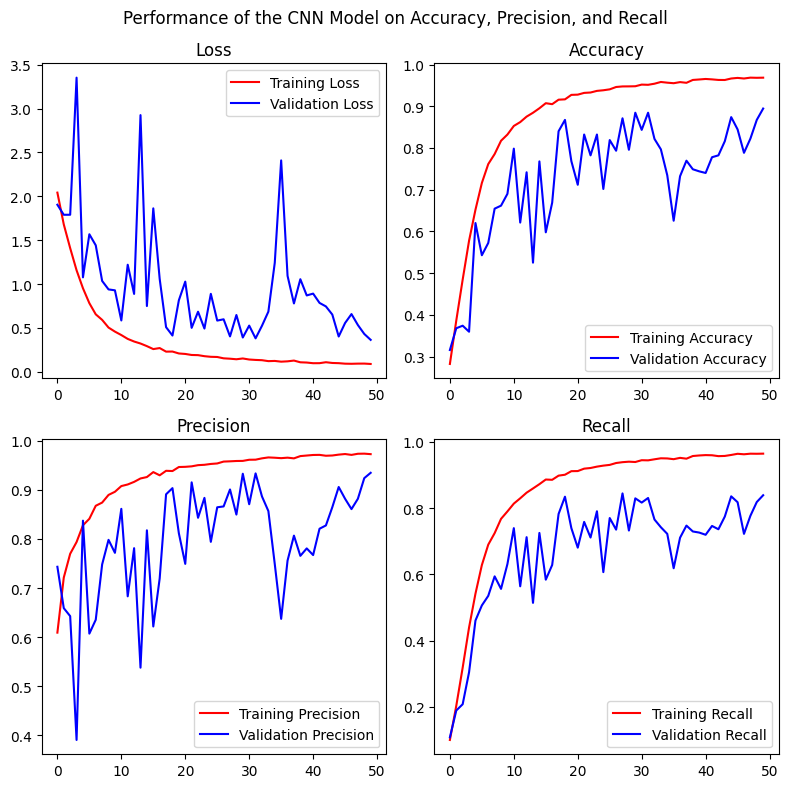

In [32]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 8))

ax1.set_title('Loss')
ax1.plot(hist.history['loss'], 'r')
ax1.plot(hist.history['val_loss'], 'b')
ax1.legend(['Training Loss', 'Validation Loss'])

ax2.set_title('Accuracy')
ax2.plot(hist.history['accuracy'], 'r')
ax2.plot(hist.history['val_accuracy'], 'b')
ax2.legend(['Training Accuracy', 'Validation Accuracy'])

ax3.set_title('Precision')
ax3.plot(hist.history['precision'], 'r')
ax3.plot(hist.history['val_precision'], 'b')
ax3.legend(['Training Precision', 'Validation Precision'])

ax4.set_title('Recall')
ax4.plot(hist.history['recall'], 'r')
ax4.plot(hist.history['val_recall'], 'b')
ax4.legend(['Training Recall', 'Validation Recall'])

fig.suptitle("Performance of the CNN Model on Accuracy, Precision, and Recall")
fig.subplots_adjust(top=0.90)
plt.tight_layout()
plt.savefig("Model_Performance.png", dpi=300)
plt.show()